# Uber Supply-Demand Gap Analysis

## Problem Statement
Uber is facing issues like - driver cancellation and non-availability of cards leading to loss of potential revenue. As an analyst, you decide to address the problem by analysing the sample data set from its warehouse.

The aim of the analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation. As a result of your analysis, you should be able to present to the client the root cause(s) and possible hypotheses of the problem(s) and recommend ways to improve them.

## Analysis approach
1) Explore the data set <br>
2) Data handling and cleaning (impute/remove missing values, rectify columns, derive new columns etc) <br>
3) Draw insights to find problem areas <br>
4) Supply Demand Gap Analysis <br>
5) Suggest solutions to rectify the problems

### 1) Explore the data set

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data set
# NOTE: Please update the below path to the location of the dataset file as per your local system
uberdata= pd.read_csv(r"C:\Users\INGIT\Downloads\Upgrad Practice\Data Mining and Discovery\Assignment_Uber Supply Demand Gap Analysis\Uber Request Data.csv")

In [3]:
# Display the first few records just to see if the data is loaded correctly
uberdata.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [4]:
# Print the information about the data
uberdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


### 2) Data Handling and Cleaning
The above info gives the data types and null values in the columns of the given data. Lets handle each column accordingly

#### a) Request id
This column doesnt have any null values. This seems to uniquely identify a request(row). Lets see if there any duplicates, and then, we could remove it from the dataset since it is of no use.

In [5]:
# Check if there are any duplicate entries based on request id (in that case we will remove duplicate rows)
uberdata['Request id'].duplicated().value_counts()
# There are no duplicate entries

False    6745
Name: Request id, dtype: int64

In [6]:
# Drop the request id as it would be of no use anymore
uberdata.drop("Request id",inplace=True,axis=1)

#### b) Pickup point
This column doesnt have any nulls. Check if there are any garbage values

In [7]:
# Check all possible values for Pickup point
uberdata["Pickup point"].value_counts()

#There seem to be no issues with this column. Possible values: [City,Airport]

City       3507
Airport    3238
Name: Pickup point, dtype: int64

#### c) Driver id
This column has null values, and float datatype. Check what rows have nulls and convert values to int since id is int only.

In [8]:
# Check rows where Driver id is null
uberdata[uberdata["Driver id"].isnull()]

,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
4095,City,NaN,No Cars Available,11/7/2016 0:02,NaN
4096,City,NaN,No Cars Available,11/7/2016 0:06,NaN
4097,City,NaN,No Cars Available,11/7/2016 0:09,NaN
4098,Airport,NaN,No Cars Available,11/7/2016 0:23,NaN
4099,Airport,NaN,No Cars Available,11/7/2016 0:30,NaN
...,...,...,...,...,...
6740,City,NaN,No Cars Available,15-07-2016 23:49:03,NaN
6741,Airport,NaN,No Cars Available,15-07-2016 23:50:05,NaN
6742,City,NaN,No Cars Available,15-07-2016 23:52:06,NaN
6743,City,NaN,No Cars Available,15-07-2016 23:54:39,NaN


In [9]:
# Since it seems Driver id is null where status is "No Cars Available", which makes sense. Lets check to confirm
uberdata[uberdata["Driver id"].isnull()].Status.value_counts()
# Lets set these null values to 0 for driver id column

No Cars Available    2650
Name: Status, dtype: int64

The above result shows that Driver id is not available where status is "No Cars Available". Hence this column values are "Missing Not at Random" (MNAR) and null values are valid

In [10]:
# Replace nulls with default value as -1, and then convert driver id to int
uberdata["Driver id"] = uberdata["Driver id"].fillna(-1).astype(int)

In [11]:
# Check the datatype of driver id again now
uberdata.info()
# It is converted to int and doesnt have any nulls now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Pickup point       6745 non-null   object
 1   Driver id          6745 non-null   int32 
 2   Status             6745 non-null   object
 3   Request timestamp  6745 non-null   object
 4   Drop timestamp     2831 non-null   object
dtypes: int32(1), object(4)
memory usage: 237.3+ KB


#### d) Status
This column has no null values. Check all possible values.

In [12]:
uberdata['Status'].value_counts()
# Doesnt seem to have garbage values

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

#### e) Request Timestamp
This column has no nulls, however the format of date needs to be standardized.
We saw dates in different formats like: "11/7/2016 13:00" and "13-07-2016 08:33:16"

In [13]:
# Check all possible values for this column
uberdata['Request timestamp'].value_counts()

11/7/2016 19:02        6
11/7/2016 17:57        6
11/7/2016 8:37         6
11/7/2016 9:40         6
12/7/2016 21:42        5
                      ..
15-07-2016 18:08:33    1
15-07-2016 04:50:54    1
14-07-2016 18:42:23    1
13-07-2016 19:26:50    1
15-07-2016 23:55:03    1
Name: Request timestamp, Length: 5618, dtype: int64

In [14]:
# Standardize date format in the column
uberdata['Request timestamp'] = pd.to_datetime(uberdata['Request timestamp'])

In [15]:
# Check the values for the column now
uberdata['Request timestamp'].value_counts()

2016-11-07 19:02:00    6
2016-11-07 17:57:00    6
2016-11-07 08:37:00    6
2016-11-07 09:40:00    6
2016-12-07 21:42:00    5
                      ..
2016-07-15 18:08:33    1
2016-07-15 04:50:54    1
2016-07-14 18:42:23    1
2016-07-13 19:26:50    1
2016-07-15 23:55:03    1
Name: Request timestamp, Length: 5618, dtype: int64

#### f) Drop timestamp
This column has nulls and the date format also needs to be standardized

In [16]:
# Check all possible values for this column
uberdata['Drop timestamp'].value_counts()

11/7/2016 13:00        4
12/7/2016 21:53        4
12/7/2016 21:04        4
12/7/2016 6:22         4
11/7/2016 18:39        3
                      ..
12/7/2016 5:40         1
12/7/2016 22:42        1
13-07-2016 13:09:40    1
13-07-2016 23:22:35    1
15-07-2016 09:56:07    1
Name: Drop timestamp, Length: 2598, dtype: int64

In [17]:
# Check some sample rows where drop timestamp is null
uberdata[uberdata['Drop timestamp'].isnull()].head()

,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
2831,City,1,Cancelled,2016-07-13 06:08:41,NaN
2832,City,1,Cancelled,2016-07-14 17:07:58,NaN
2833,Airport,1,Cancelled,2016-07-14 20:51:37,NaN
2834,City,1,Cancelled,2016-07-15 10:12:40,NaN
2835,Airport,2,Cancelled,2016-12-07 19:14:00,NaN


In [18]:
# From above, it seems that drop timestamp is missing where status is Cancelled, which makes sense. Lets check all possible status values where its null
uberdata[uberdata['Drop timestamp'].isnull()].Status.value_counts()

No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

The above result shows that Drop timestamp is not available where status is "No Cars Available/Cancelled". Hence it is "Missing Not at Random" (MNAR) and null values are valid

In [19]:
# Standardize date format in the column
uberdata['Drop timestamp'] = pd.to_datetime(uberdata['Drop timestamp'])

In [20]:
uberdata['Drop timestamp'].value_counts()

2016-11-07 13:00:00    4
2016-12-07 21:53:00    4
2016-12-07 21:04:00    4
2016-12-07 06:22:00    4
2016-11-07 18:39:00    3
                      ..
2016-12-07 05:40:00    1
2016-12-07 22:42:00    1
2016-07-13 13:09:40    1
2016-07-13 23:22:35    1
2016-07-15 09:56:07    1
Name: Drop timestamp, Length: 2598, dtype: int64

#### i) Extracting more meaningful columns for better analysis
Lets also extract the date, time, day and hour from the Request timestamp. They could be useful for our analysis.

In [21]:
# Extracting values from the request datetime column to get more details
uberdata['requestDate'] = uberdata['Request timestamp'].dt.date
uberdata['requestTime'] = uberdata['Request timestamp'].dt.time
uberdata['requestDayOfWeek'] = uberdata['Request timestamp'].dt.day_name()
uberdata['requestHour'] = uberdata['Request timestamp'].dt.hour

In [22]:
# print head to see the result
uberdata.head()

,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,requestDate,requestTime,requestDayOfWeek,requestHour
0,Airport,1,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,2016-11-07,11:51:00,Monday,11
1,Airport,1,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,2016-11-07,17:57:00,Monday,17
2,City,1,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,2016-12-07,09:17:00,Wednesday,9
3,Airport,1,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,2016-12-07,21:08:00,Wednesday,21
4,City,1,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13,08:33:16,Wednesday,8


In [23]:
# print head to see the result
uberdata.head()

,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,requestDate,requestTime,requestDayOfWeek,requestHour
0,Airport,1,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,2016-11-07,11:51:00,Monday,11
1,Airport,1,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,2016-11-07,17:57:00,Monday,17
2,City,1,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,2016-12-07,09:17:00,Wednesday,9
3,Airport,1,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,2016-12-07,21:08:00,Wednesday,21
4,City,1,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13,08:33:16,Wednesday,8


In [24]:
# Initializing totalRequests variable for later use
totalRequests = len(uberdata)
totalRequests

6745

### 3) Draw insights to find problem areas
Start analysing the data to get insights and create visualizations

#### a) Analyse the Status Column

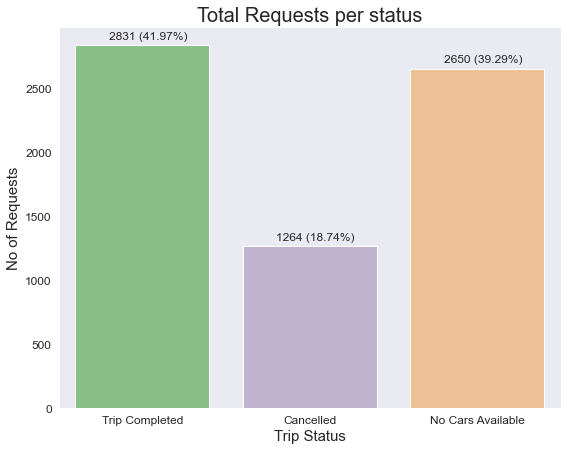

In [25]:
plt.figure(figsize=(9, 7))
sns.set_style("dark")
sns.set_palette("Accent")
plt.title("Total Requests per status",fontdict={'fontsize': 20, 'fontweight' : 5})
ax =sns.countplot(x="Status", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.2
    Y = p.get_height()+50
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Trip Status",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# This tell us that less than half (41.97%) of the total requests get completed only. Hence, there is a huge problem.
# About 39.29% of the requests are not successful due to unavailability of cars, while 18.74% requests are not successful due to rides being cancelled.

#### b) Analyse the Pickup Point Column

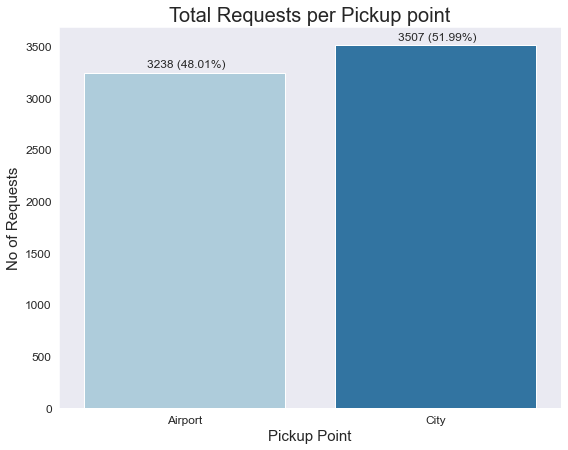

In [26]:
plt.figure(figsize=(9, 7))
plt.title("Total Requests per Pickup point",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Paired")
ax =sns.countplot(x="Pickup point", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.25
    Y = p.get_height()+55
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Pickup Point",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# There is almost an equal number of requests from the City and the Airport

#### c) Analyse the Day of the Week Column
We will see number of requests per DayOfTheWeek

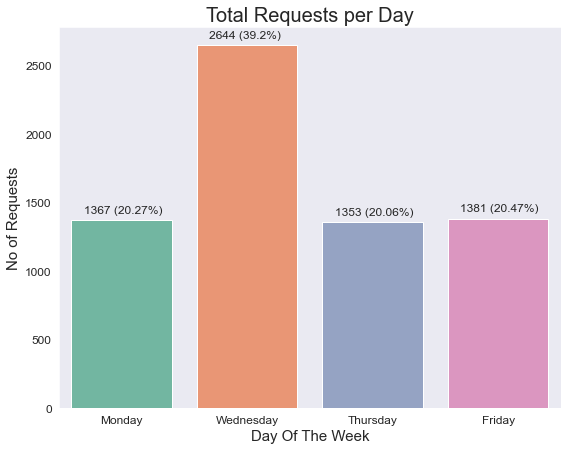

In [27]:
plt.figure(figsize=(9, 7))
plt.title("Total Requests per Day",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestDayOfWeek", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.1
    Y = p.get_height()+55
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Day Of The Week",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# The requests are generally distributed equally among other days, except on Wednesday. This could be since we have sample data for only a specific week.
# We could say that the requests are higher on Wednesday, but can't conclude this for sure, due to lack of data of more data for other weeks.
# So lets not conclude much from this insight

#### d.i) Analyse the Hour Column
We will see number of requests per Hour in the day

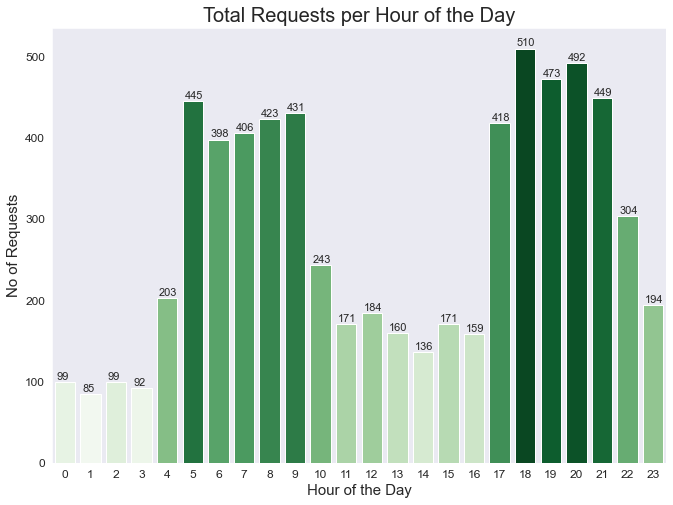

In [28]:
plt.figure(figsize=(11, 8))
plt.title("Total Requests per Hour of the Day",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
requestsPerHour = uberdata.groupby("requestHour").size()
pal = sns.color_palette("Greens", len(requestsPerHour))
rank = requestsPerHour.argsort().argsort()
ax =sns.countplot(x="requestHour", data=uberdata, palette=np.array(pal[::])[rank])
for p in ax.patches:
    value = p.get_height()
    X = p.get_x()+0.08
    Y = p.get_height()+3
    ax.text(X, Y, value,size=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# It shows that requests are very high between 5-9(5am to 9am)[31.17%] and then fall suddenly between 10-16(10am to 4pm)[18.14%],
# and then surge again between 5-10(5pm to 10pm)[39.2%]. The requests are the least between 0-3(12am to 3am)[5.55%]

In [29]:
# Lets divide the hours into various slots for better analysis based on the above graph
uberdata.loc[uberdata['requestHour'].between(0,3, inclusive=True),'requestSlot'] = 'Late night'
uberdata.loc[uberdata['requestHour'].between(4,6, inclusive=True),'requestSlot'] = 'Early morning'
uberdata.loc[uberdata['requestHour'].between(7,11, inclusive=True),'requestSlot'] = 'Morning'
uberdata.loc[uberdata['requestHour'].between(12,16, inclusive=True),'requestSlot'] = 'Afternoon'
uberdata.loc[uberdata['requestHour'].between(17,20, inclusive=True),'requestSlot'] = 'Evening'
uberdata.loc[uberdata['requestHour'].between(21,23, inclusive=True),'requestSlot'] = 'Night'

# Creating an array to ordered timeslot labels for later use
timeSlotLabels = ['Late night','Early morning','Morning','Afternoon','Evening','Night']

## NOTE:

We have extracted the hours from the timestamp(which follows 24 hours clock format) and clubbed them as below(left and right inclusive): <br>
<b>0-3 : Late Night <br>
4-6 : Early Morning <br>
7-11 : Morning <br>
12-16 : Afternoon <br>
17-20 : Evening <br>
21-23 : Night <br>
</b>


For instance,
- If request time is "03:10“(3:10am), then the extracted hour is "3", and hence it will be considered Late night
- If request time is "20:59“(8:59pm), then the extracted hour is "20", and hence it will be considered Evening

#### d.ii) Analyse the RequestSlot Column
We will see number of requests per TimeSlot in the day

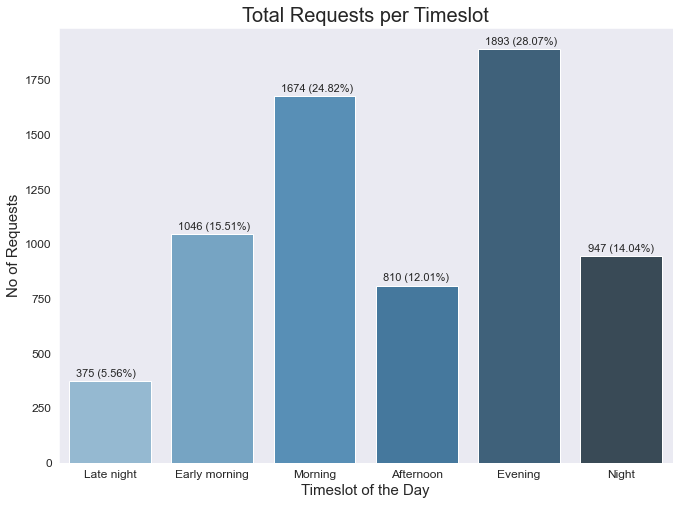

In [30]:
# Clubbing the above data in slots to get a better visualization
plt.figure(figsize=(11, 8))
plt.title("Total Requests per Timeslot",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Blues_d")
ax =sns.countplot(x="requestSlot", data=uberdata, order=timeSlotLabels)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.07
    Y = p.get_height()+20
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# Requests start increasing from the Early morning(15.51%) reaching a peak in the Morning(24.82%), after which there is a sudden decline in the requests all Afternoon(12.01%).
# Then there is another peak in requests during the Evening(28.07%) which drops at Night(14.04%). The requests are minimum during Late night(5.56%)

#### ANALYSIS SO FAR:
- Only 41.97% of the requests are successfully fulfilled. A major issue for unfulfilled requests is Cab unavailability(39.29%), while 18.74% of requests are cancelled.
- Requests are very high between 5-9(5am to 9am)[31.17%] and then fall suddenly between 10-16(10am to 4pm)[18.14%], and then surge again between 5-10(5pm to 10pm)[39.2%]. The requests are the least between 0-3(12am to 3am)[5.55%]
- Peak slots are Morning and Evening when we have maximum number of requests

#### e) Analyse the number of requests per Pickup point based on Status

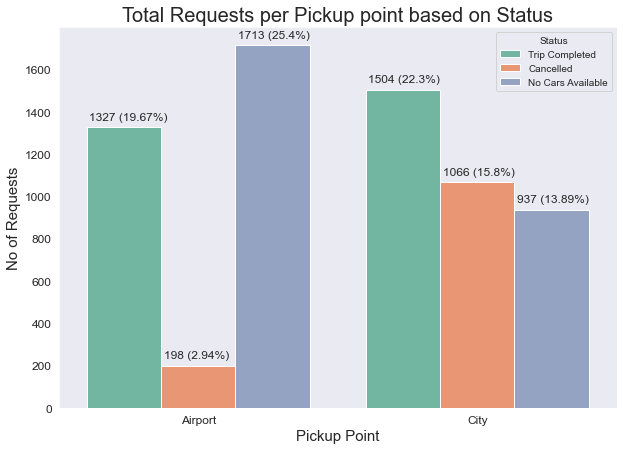

In [31]:
plt.figure(figsize=(10, 7))
plt.title("Total Requests per Pickup point based on Status",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="Pickup point", hue="Status", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.01
    Y = p.get_height()+35
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Pickup Point",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# This tells us that the major number of unfulfilled trips at airport are due to "No Cars Available"(25.4%).
# and in the City, about 15.8% requests are unsuccessful due to cancellations, while 13.89% requests are unsuccessful due to "No Cars Available"

#### f) Analyse the number of requests per Hour of the Day based on Pickup Point

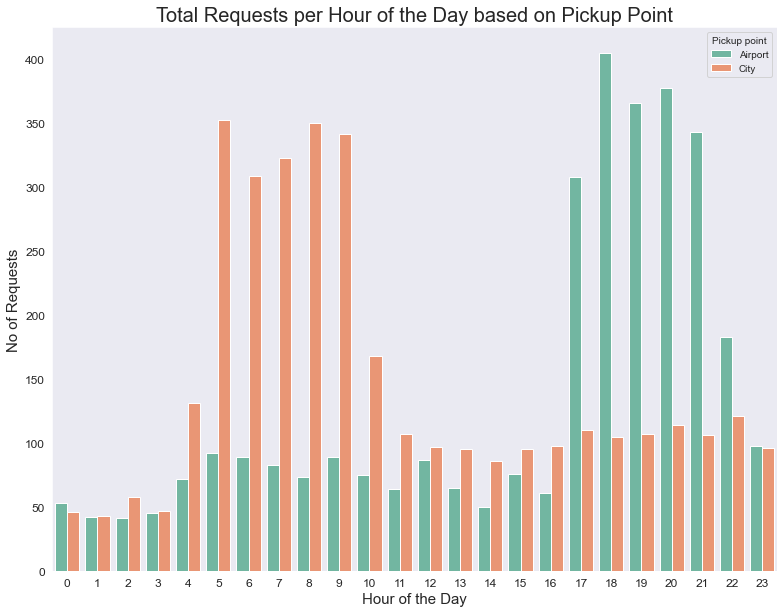

In [32]:
plt.figure(figsize=(13, 10))
plt.title("Total Requests per Hour of the Day based on Pickup Point",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestHour", hue="Pickup point", data=uberdata)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# It shows that generally most of the requests are from City to the Airport during the morning hours from 5am to 10am
# while the requests from airport to city during the evening hours 5pm-10pm

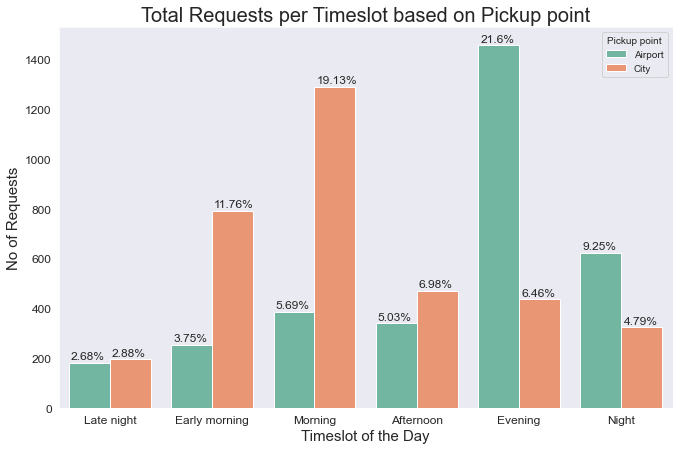

In [33]:
# Lets see the above graph by clubbing individual hours as timeslots
plt.figure(figsize=(11, 7))
plt.title("Total Requests per Timeslot based on Pickup point",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestSlot", hue="Pickup point", data=uberdata, order=timeSlotLabels)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.02
    Y = p.get_height()+15
    ax.text(X, Y, '{}%'.format(percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# The graph indicates that there is a huge number of requests from the City to the Airport during the Early morning(11.76%) and Morning slots(19.13%)
# ,while a huge number of requests from the Airport to the City during the Evening slots(21.6%).

#### g) Analyse the number of requests per Hour based on Status

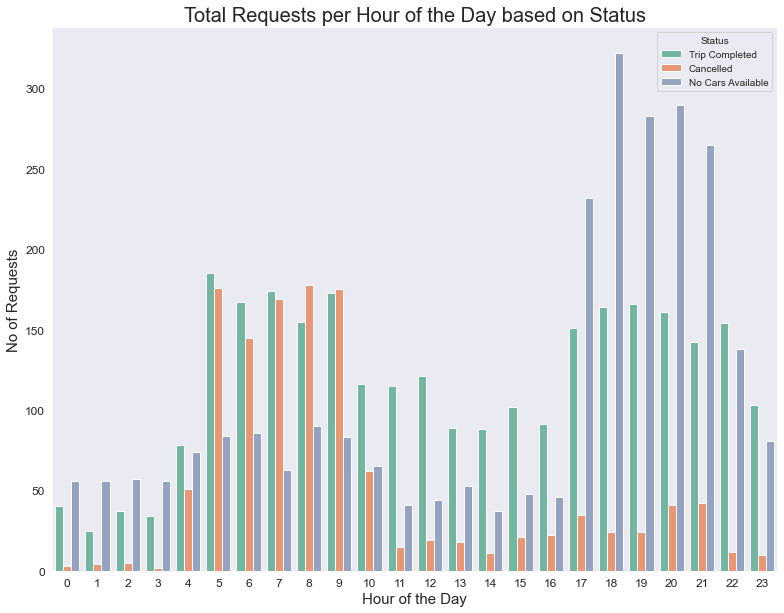

In [34]:
# i) Plotting this as separate bars for each Status
plt.figure(figsize=(13, 10))
plt.title("Total Requests per Hour of the Day based on Status", fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestHour", hue="Status", data=uberdata)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# It shows that the requests are higher during the hours 5am to 10am and during hours 5pm to 10pm, they are the least between 12am to 3am
# This also tells that the there is a high number of cancellation of rides during the hours 5am to 9am, and high number of unsuccessful trips due to "No cars available" during the hours 17-21

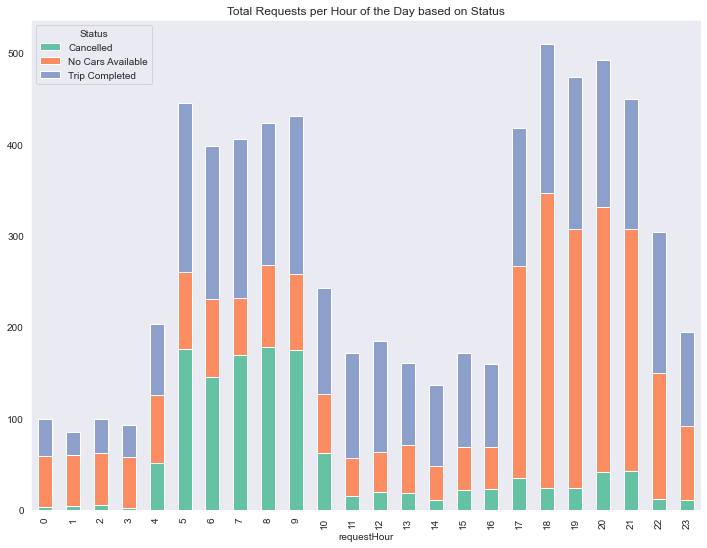

In [35]:
# ii) Plotting this as Stacked bars for each Status
numreq = pd.pivot_table(data=uberdata,values='Driver id',index='requestHour',columns='Status',aggfunc="count")
numreq.plot(kind='bar',stacked=True, figsize=[12,9], title="Total Requests per Hour of the Day based on Status")
plt.show()
# This gives a better idea of the magnitude of total requests per hour divided by Status

#### h) Analyse the number of requests per TimeSlot of the Day based on Status

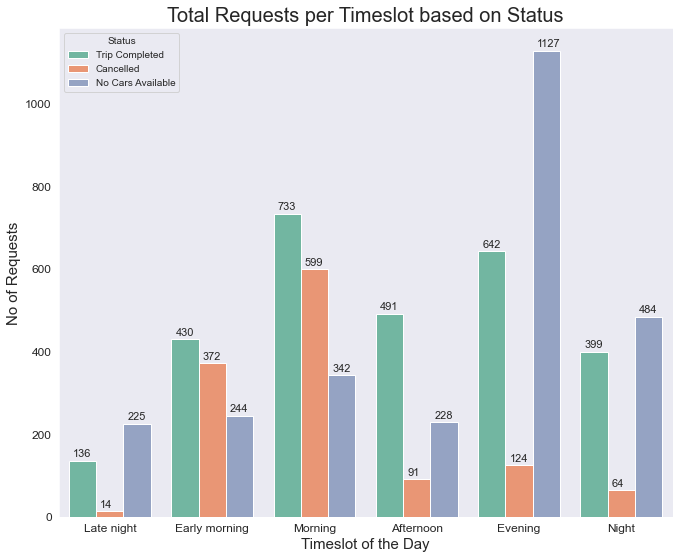

In [36]:
plt.figure(figsize=(11, 9))
plt.title("Total Requests per Timeslot based on Status",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestSlot", hue="Status", data=uberdata, order=timeSlotLabels)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.04
    Y = p.get_height()+10
    ax.text(X, Y, '{}'.format(value),size=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# Seems like requests are highest during the morning and evening times, while it is least during the Late night
# Major issues in the mornings are High cancellations followed by Car unavailability, while major issue during the evening is Car unavailability.

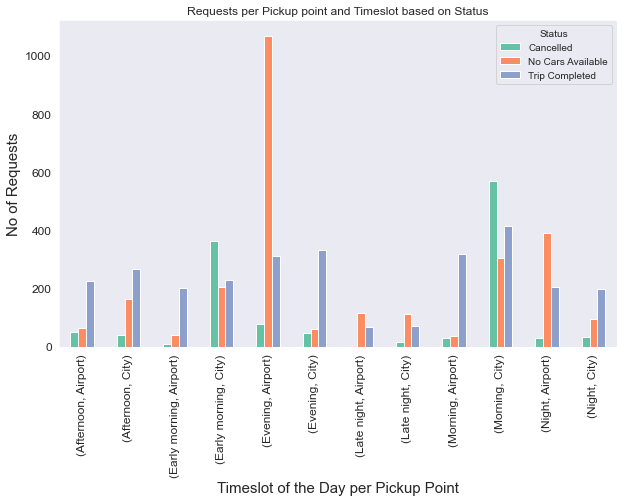

In [37]:
#Plot to count the number of requests that were in different Status, for the final analysis
requestPerSlotPerPickupPerStatus_df = pd.DataFrame(uberdata.groupby(['requestSlot','Pickup point','Status'])['Status'].count().unstack(fill_value=0))
sns.set_style("dark")
sns.set_palette("Set2")
ax = requestPerSlotPerPickupPerStatus_df.plot.bar(figsize = (10, 6),title="Requests per Pickup point and Timeslot based on Status")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day per Pickup Point",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

#### ANALYSIS SO FAR:
- <b>From City to Airport:</b>
  The requests are high during Early morning and Morning slots, but there are a huge number of cancellations. We also see some shortage of Cars
- <b>From Airport to City:</b>
  The requests are high during Evening slots, but there is a huge unavailability of cars.

In [38]:
# Lets see how many requests are made to the drivers each day 
driverData = uberdata.groupby(['requestDayOfWeek','Driver id']).size().reset_index(name='counts')

# Lets remove data where Driver id is -1, since those rides were not fulfilled.
driverData = driverData[driverData["Driver id"]!=-1]
driverData.head()

,requestDayOfWeek,Driver id,counts
1,Friday,1,3
2,Friday,3,2
3,Friday,4,2
4,Friday,5,2
5,Friday,6,6


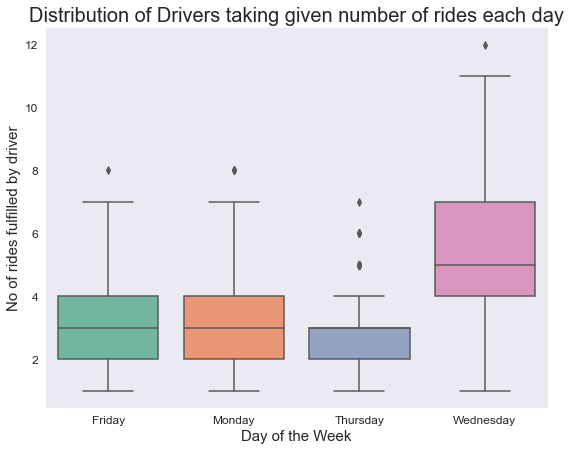

In [39]:
# Lets see how is the spread of number of requests received by drivers each day
plt.figure(figsize=(9, 7))
plt.title("Distribution of Drivers taking given number of rides each day",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
sns.boxplot(data=driverData,x="requestDayOfWeek",y="counts")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Day of the Week",size=15)
plt.ylabel("No of rides fulfilled by driver",size=15)
plt.show()

# The below shows that there is almost a medium spread of rides among the riders each day
# However, as we see there are drivers for instance on Wednesday, who are fulfilling about 8-12 rides, while few are only fulfilling 1-4 rides.
# Maybe uber can also look into this and come up with some ways to spread the number of rides almost evenly among more drivers throughout the day.
# We could put a daily target for the number of rides to be completed by each driver based on the average number of rides per day.

### 4) Supply Demand Gap Analysis
Lets visualize all the insights with respect to Supply, Demand and Gap

#### Creating Supply, Demand and Gap values for analysis

In [40]:
# Lets assign Demand as value 1. Since all the requests indicate a demand, hence we can do below
uberdata["Demand"] = 1

In [41]:
# The requests with status "Trip completed" can be referred as supply. Lets mark them as 1 when "Trip Completed", else 0
uberdata['Supply'] = 0
uberdata.loc[(uberdata['Status'] == 'Trip Completed'),'Supply'] = 1

In [42]:
# Lets create a column called Gap that will indicate whether the trip was fulfilled or not
uberdata['Gap'] = uberdata['Demand'] - uberdata['Supply']
# The above will indicate that wherever Gap is 0, the trip is complete, else not complete
uberdata.loc[uberdata['Gap']==0,'Gap'] = 'Fulfilled'
uberdata.loc[uberdata['Gap']==1,'Gap'] = 'Not Fulfilled'

In [43]:
# Print head to see the result
uberdata.head()

,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,requestDate,requestTime,requestDayOfWeek,requestHour,requestSlot,Demand,Supply,Gap
0,Airport,1,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,2016-11-07,11:51:00,Monday,11,Morning,1,1,Fulfilled
1,Airport,1,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,2016-11-07,17:57:00,Monday,17,Evening,1,1,Fulfilled
2,City,1,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,2016-12-07,09:17:00,Wednesday,9,Morning,1,1,Fulfilled
3,Airport,1,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,2016-12-07,21:08:00,Wednesday,21,Night,1,1,Fulfilled
4,City,1,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13,08:33:16,Wednesday,8,Morning,1,1,Fulfilled


#### Analysis of Demand per Hour of the Day

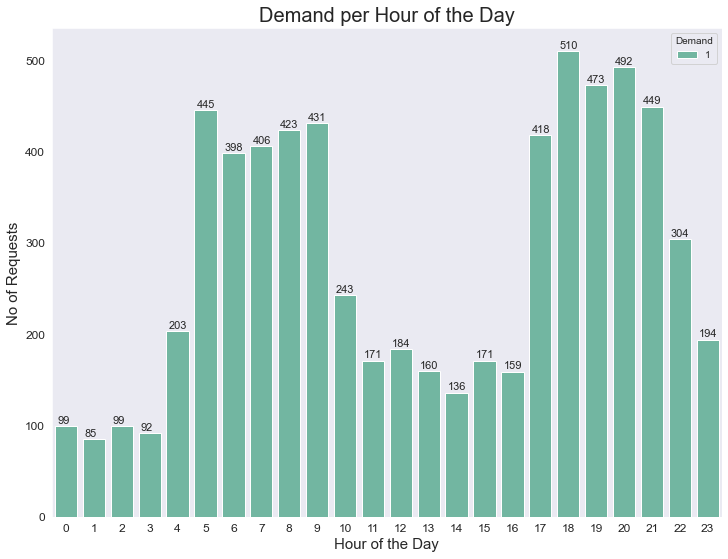

In [44]:
# Plot a graph to show the demand per hour of the day
plt.figure(figsize=(12, 9))
plt.title("Demand per Hour of the Day",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestHour", hue="Demand", data=uberdata)
for p in ax.patches:
    value = p.get_height()
    X = p.get_x()+0.08
    Y = p.get_height()+3
    ax.text(X, Y, value,size=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# This tells that the demand is very high between 5-9(5am to 9am)[31.17%] and then falls suddenly between 10-16(10am to 4pm)[18.14%], and then surges again between 5-10(5pm to 10pm)[39.2%].
# The demand is the least between 0-3(12am to 3am)[5.55%].

#### Analysis of Demand per Pickup point

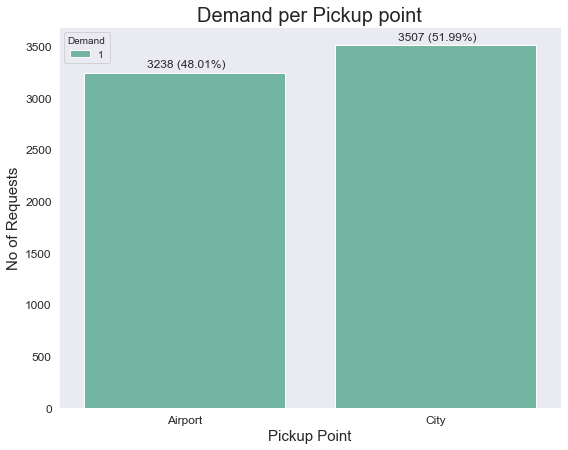

In [45]:
# Plot a graph to show the demand per Pickup point
plt.figure(figsize=(9, 7))
plt.title("Demand per Pickup point",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="Pickup point", hue="Demand", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.25
    Y = p.get_height()+55
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Pickup Point",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# There is almost an equal demand from the City and the Airport

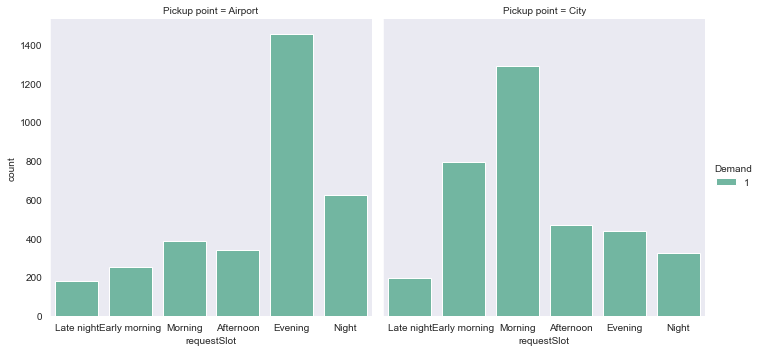

In [46]:
#segmenting Demand across the pickup point and request timeslot
sns.catplot(x='requestSlot',col="Pickup point", hue ="Demand",data=uberdata , kind="count", order=timeSlotLabels)
plt.show()
# The demand is high During Early morning and Morning slot in the City while high during Evening slot at the Airport
# The demand is very low at the Airport during Late night, Early morning, Morning, and Afternoon slots
# The demand is very low in the Cityr during the Late night, Afternoon, Evening and Night slots

#### Analysis of Gap

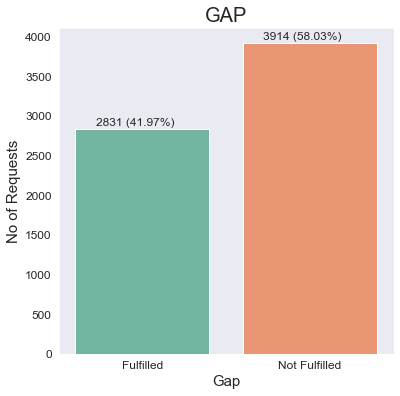

In [47]:
# Plot a graph to indicate the Gap
plt.figure(figsize=(6, 6))
plt.title("GAP",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="Gap", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.12
    Y = p.get_height()+45
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Gap",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()
# There is a 58.03% Gap as "Not fulfilled", which means 58.03% requests are unfulfilled.

#### Analysis of Gap per Pickup point

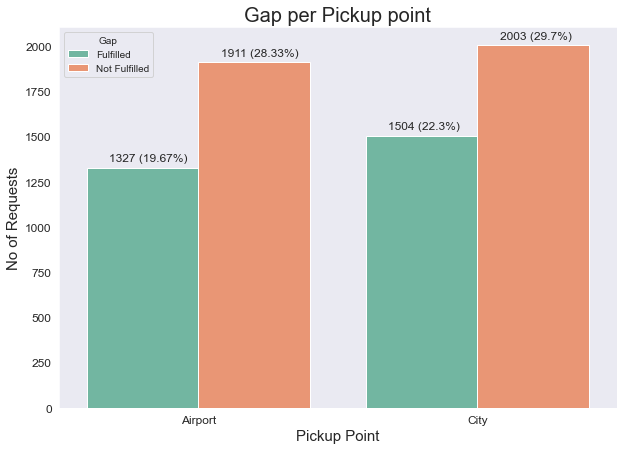

In [48]:
# Plot a graph to show the Gap per pickup point
plt.figure(figsize=(10, 7))
plt.title("Gap per Pickup point",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="Pickup point", hue="Gap", data=uberdata)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    value = p.get_height()
    X = p.get_x()+0.08
    Y = p.get_height()+35
    ax.text(X, Y, '{} ({}%)'.format(value,percentageValue),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Pickup Point",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()
# 28.33% "Not Fulfilled" Gap at the Airport while 29.7% "Not Fulfilled" Gap in the City.

#### Analyses of Gap per Hour of the Day

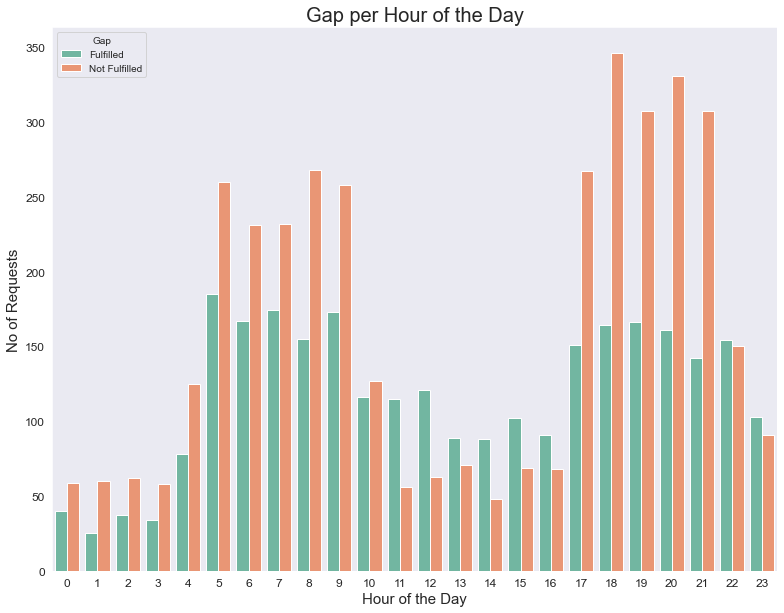

In [49]:
# Plot a graph to show the Gap per Hour of the Day
plt.figure(figsize=(13, 10))
plt.title("Gap per Hour of the Day",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestHour", hue="Gap", data=uberdata)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# It shows that generally there is a huge unfulfilled gap during the Morning hours 5am to 10am and the Evening hours 5pm to 10pm

#### Analyses of Gap per TimeSlot

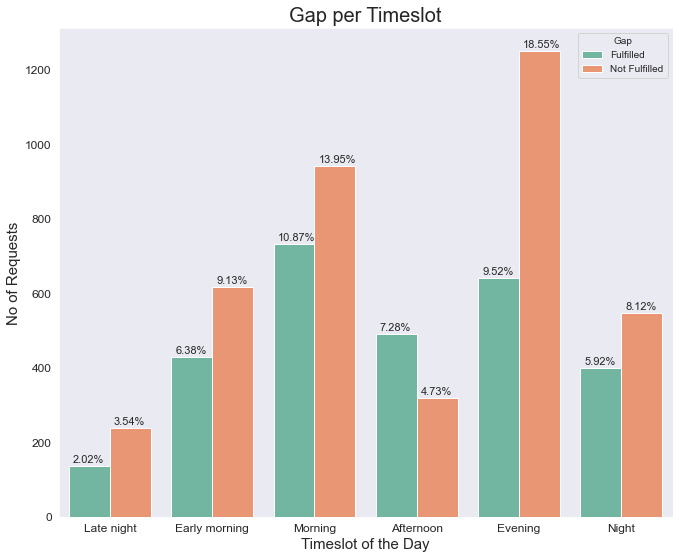

In [50]:
# Plot a graph to show the Gap per Timeslot
plt.figure(figsize=(11, 9))
plt.title("Gap per Timeslot",fontdict={'fontsize': 20, 'fontweight' : 5})
sns.set_style("dark")
sns.set_palette("Set2")
ax =sns.countplot(x="requestSlot", hue="Gap", data=uberdata, order=timeSlotLabels)
for p in ax.patches:
    percentageValue = round((p.get_height()/totalRequests)*100,2)
    X = p.get_x()+0.04
    Y = p.get_height()+10
    ax.text(X, Y, '{}%'.format(percentageValue),size=11)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day",size=15)
plt.ylabel("No of Requests",size=15)
plt.show()

# The unfulfilled Gap is highest during the Early morning(9.13%), Morning(13.95%) and Evening slots(18.55%), while it is least during the Late night slot(3.45%).

#### Analysis of Gap per Pickup point and Timeslot

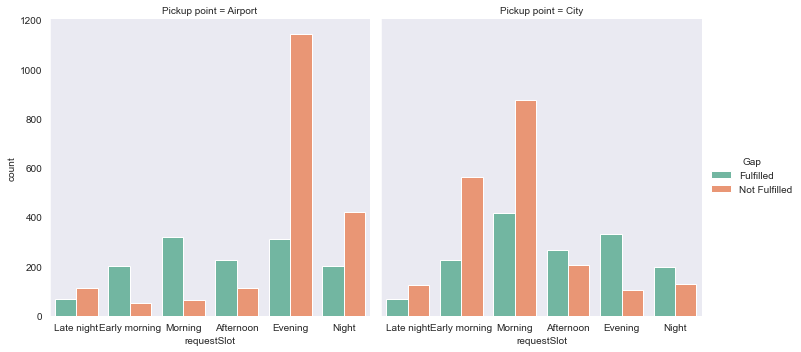

In [51]:
#segmenting gap across the pickup point and request timeslot
sns.set_style("dark")
sns.set_palette("Set2")
sns.catplot(x='requestSlot',col="Pickup point", hue ="Gap", data=uberdata ,kind="count", order=timeSlotLabels)
plt.show()
# There is a huge unfulfilled Gap at the Airport during Evening and Night slots, while hige unfulfilled Gap in the City during Early morning and Morning slots

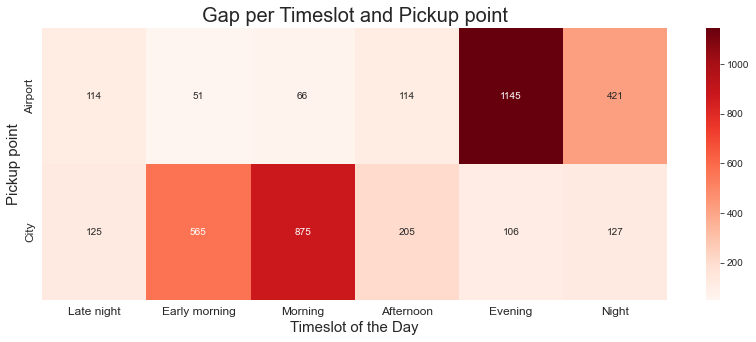

In [52]:
# Plotting a heatmap of Gap per pickup point and timeslot to show the problem area identified so far
plt.figure(figsize=(14,5))
plt.title("Gap per Timeslot and Pickup point",fontdict={'fontsize': 20, 'fontweight' : 5})

# Converting Gap to numeric value for below Graph. Gap = 0 means fulfilled , and Gap = 1 means Not fulfilled
uberdata.loc[uberdata['Gap']=="Fulfilled",'Gap'] = 0
uberdata.loc[uberdata['Gap']=="Not Fulfilled",'Gap'] = 1

gapPerPickupAndTimeslot = pd.pivot_table(data=uberdata,index='Pickup point',columns='requestSlot',values='Gap',aggfunc=np.sum).reindex(timeSlotLabels,axis=1)
sns.heatmap(gapPerPickupAndTimeslot,cmap="Reds",annot=True,fmt="d")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Timeslot of the Day",size=15)
plt.ylabel("Pickup point",size=15)
plt.show()
# There is a huge unfulfilled Gap at the Airport during Evening and Night slots
# ,while huge unfulfilled Gap in the City during Early morning and Morning slots

# Observations from the analysis
- Only 41.97% of requests are fulfilled successfully. Through the Supply, Demand and Gap parameters, we are able to identify that there is a huge gap between the Supply and Demand and hence some measures need to be taken to improve Uber's Revenue
- There is a high demand for rides from the City to the Airport during the Early morning(15.51%) and Morning(24.82%), and from Airport to City during the Evening(28.07%). However, there is very less demand at these pickup points for the remaining slots respectively.
- This could be the reason why the Cab drivers are cancelling the rides from the City to Airport because there is no longer much demand till the evening at the Airport and they will have to wait till then or come back to the city idly.
- This could also be the reason why there are a huge number of unfulfilled demands from the Airport to the City in the evening because there are not many drivers around the airport
- There is a greater failure due to "No cars available“(39.29%) than "Cancelled“(18.74%) in general. This could mean, that we should look into the shortage of Cabs and possibly increase the number of drivers to fulfill this Gap.
- We also see that the rides are not evenly spread for all the drivers, and there is scope to improve that spread as well to reduce the workload on a few drivers.


### PEAK MORNING ISSUE (CITY TO AIRPORT):
* As per the analysis, there is a huge demand from City to the Airport in the morning hours(5am to 10am) and a large number of requests are being cancelled, leading to an increase in the Supply & Demand Gap. There is a shortage of drivers as well leading to further increase in the Gap.
* The high demand could be due to a lot of morning flights departing from the City.
* The supply could be less because the drivers might not be willing to travel that far to the airport from the city during the morning possibly because there is less demand from the Airport back to the City during the afternoon. The drivers might not prefer waiting that long or coming back idle to the city. They may prefer taking smaller rides within the City itself.

### PEAK EVENING ISSUE (AIRPORT TO CITY):
* As per the analysis, there is a huge demand from Airport to the City in the evening(5pm to 10pm) and but there is a huge shortage of drivers, leading to an increase in the Supply & Demand Gap.
* The high demand could be due to a lot of evening flights arriving in the City.
* The supply could be less since not many drivers are willing to come to the airport in the morning, leading to fewer drivers in the area by the evening.

### 5) Suggest solutions to rectify the problems

## RECOMMENDATIONS BASED ON ANALYSIS
* Add dedicated Uber stands at the airport making cabs available all the time, thus reducing the unfulfilled requests
* Add a few more Uber drivers since a major reason for unfulfilled trips is "No cars available“(39.29%)
* Incentivize drivers for taking rides to the Airport during peak hours. This would encourage them to take more rides from City to the Airport, thus reducing the number of cancellations. (Positive reinforcement)
* Deduct a small fee from the drivers who frequently cancel the rides, thus reducing the number of cancellations. (Negative reinforcement)
* Promote pre-booking among the customers by giving some discounts so that the drivers are well aware of the schedule in advance and can plan their routine accordingly.
* Have some discussion with the drivers and share the analysis with them, talk about peak hours and opportunities, so that they know when and where to be during the day to fulfill more requests.
* Enhance the algo to find drivers, prioritizing the drivers who have taken lesser rides during the day so far, thereby ensuring even distribution of rides among the drivers